# Normalizing flows

This notebook contaings the exercises for the normalizing flows of the course.

First, we will have a very simple example using coupling blocks to perform the generation of the make moons dataset

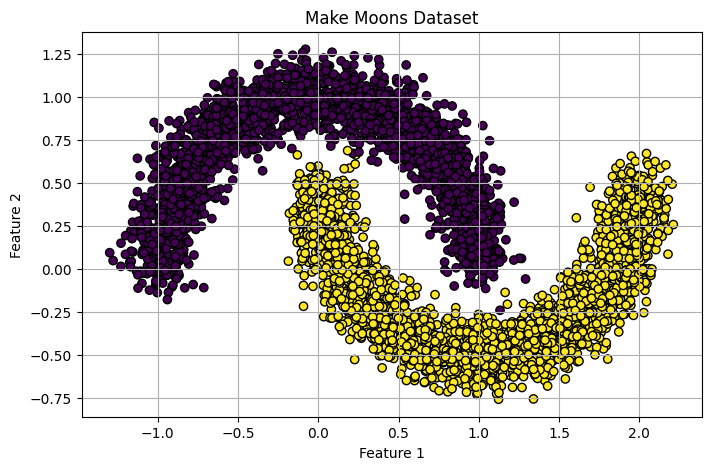

In [ ]:
# lets start by generating our dataset, which can be easily done using sklear
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Parameters
n_samples = 5000  # Number of data points
noise = 0.1      # Noise level of the data

# Generate the dataset
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('Make Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [49]:
# Now lets import them to keras tensors
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np

# Convert the data to tensors
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)

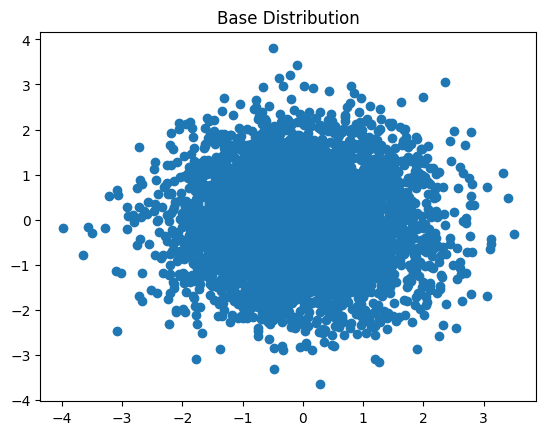

In [50]:
# Now we have also to create the base distirbution to allows us to calculate the log likelihood
def create_2d_gaussian(𝜇=0, 𝜎=1.0):
    return tfd.MultivariateNormalDiag(
        loc=[𝜇, 𝜇],
        scale_diag=[𝜎, 𝜎]
    )

# Lets plot our base distribution to check its behaviour
#import matplotlib.pyplot as plt
#%matplotlib inline

gaussian_2d_base_dist = create_2d_gaussian()
gaussian_2d_samples = gaussian_2d_base_dist.sample(5000)
plt.scatter(gaussian_2d_samples[:, 0], gaussian_2d_samples[:, 1])
plt.title("Base Distribution")
plt.show()

# In the first exercise we will only use one single transformation

In [51]:
# Still need to implement the masks in order to transform only one chunk!
class CouplingFlow:
    def __init__(self):
        # Initialize the models for s and t transformations
        self.model_s = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(2,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(2)  # No activation, output can be any real number
        ])
        
        self.model_t = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(2,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(2)  # No activation, output can be any real number
        ])

    def base_distribution(self):
        # Base distribution N(0,I)
        return tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])

    def log_prob(self, inputs, outputs):
        # Compute the log probability of the base distribution
        log_prob = self.base_distribution().log_prob(outputs)

        # Assuming model_s directly outputs the log-determinant contributions
        s_out = self.model_s(inputs)
        jacobian_log_det = tf.reduce_sum(s_out, axis=1)
        
        # Combine the log probabilities
        return tf.reduce_mean(log_prob + jacobian_log_det)
    
    # Need to implement the mask in order to transform only x1 or x2 ...
    def forward(self, inputs):
        s_out = self.model_s(inputs)
        t_out = self.model_t(inputs)
        
        # the output of model_s is effectvely exp(s), and so the log is only s!
        outputs = inputs * tf.exp(s_out) + t_out
        loss = -self.log_prob(inputs, outputs)
        return outputs, loss
        
        

In [52]:
# Now, the training loop!
model = CouplingFlow()

## I think it would be better to create a class here, no?
optimizer = tf.keras.optimizers.Adam()

In [53]:
def train(model, X_train, epochs):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            _, loss = model.forward(X_train)
        grads = tape.gradient(loss, model.model_s.trainable_variables + model.model_t.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.model_s.trainable_variables + model.model_t.trainable_variables))
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
        

In [54]:
train(model, X_tensor, epochs=500)

Epoch 0, Loss: 2.5277140140533447
Epoch 100, Loss: -1.9675589799880981
Epoch 200, Loss: -4.436082363128662
Epoch 300, Loss: -5.307180881500244
Epoch 400, Loss: -5.842312335968018


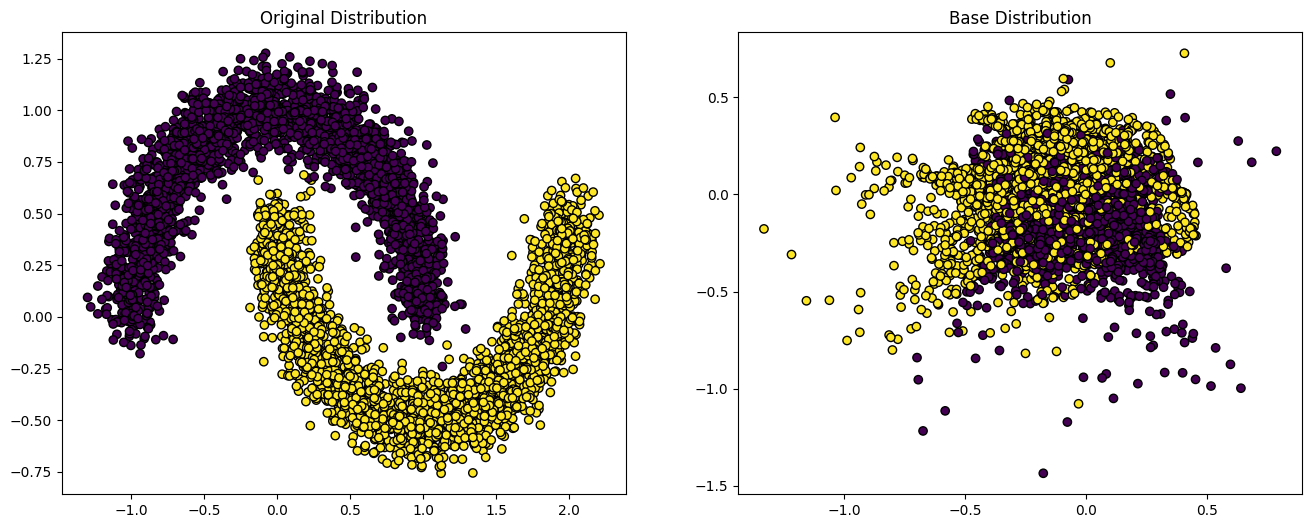

In [55]:
# Now lets check the model !!!!!
outs, _ = model.forward(X_tensor)

# Now, plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

axs[0].scatter(X_tensor[:, 0], X_tensor[:, 1], c = y_tensor, cmap='viridis', edgecolor='k')
axs[0].set_title("Original Distribution")

axs[1].scatter(outs[:, 0], outs[:, 1],  c = y_tensor, cmap='viridis', edgecolor='k')
axs[1].set_title("Base Distribution")


plt.show()

